In [10]:
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
import json
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
from pycocotools import mask as maskUtils

%matplotlib inline 

In [11]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [12]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [13]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5


config = ShapesConfig()
#config.display()

In [14]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, IMG_PATH, LBL_PATH):
        """
        Loads images from /images/
        """
        # Add classes
        self.add_class("smt", 1, "R")
        self.add_class("smt", 2, "C")
        self.add_class("smt", 3, "L")
        self.add_class("smt", 4, "D")
        self.add_class("smt", 5, "Q")
        self.add_class("smt", 6, "X")
        self.add_class("smt", 7, "Misc")
        self.add_class("smt", 8, "Unclassified" )

        # Add images
        onlyfiles = [f for f in listdir(IMAGE_DIR) if isfile(join(IMAGE_DIR, f))]
        
        
        for i in onlyfiles:
            IMAGE_PATH = os.path.join(IMAGE_DIR, i)
            IMAGE_LABEL_PATH = LBL_PATH + "\\" + i[:-4] + "__labels.json"
            print(IMAGE_LABEL_PATH)
            json_annotaion_file=open(IMAGE_LABEL_PATH).read()
            annotation = json.loads(json_annotaion_file)            
            
            print(IMAGE_PATH)
            with Image.open(IMAGE_PATH) as img:
                width, height = img.size

            self.add_image("smt", image_id=i, path=IMAGE_PATH, width=width, height=height, annotation=annotation)
         

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "smt":
            return info["smt"]
        else:
            super(self.__class__).image_reference(self, image_id)

            
    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks."""
        
        
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]        

        instance_masks = []
        class_ids = []             
        annotations = self.image_info[image_id]['annotation']['labels'] 
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.    
        class_map = {"R":1, "C":2, "L":3, "D":4, "Q":5, "X":6, "Misc":7, "Unclassified":8} 
        
        for annotation in annotations:            
            #class_id = annotation["label_class"]    
            if annotation["label_class"] == None:
                class_id = class_map["Unclassified"]                
            else:
                class_id = class_map[annotation["label_class"]]
            
            
            if class_id:
                m = self.annToMask(annotation, image_info["height"], image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                
                instance_masks.append(m)
                class_ids.append(class_id)        
        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(CocoDataset, self).load_mask(image_id)
        
        
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        if ann['label_type'] == "box":
            centre_x_y = ann['centre']            
            size_x_y = ann['size']                
            
            segm = [centre_x_y['x'] - size_x_y['x']/2,centre_x_y['y'] + size_x_y['y']/2,
                   centre_x_y['x'] - size_x_y['x']/2,centre_x_y['y'] - size_x_y['y']/2,
                   centre_x_y['x'] + size_x_y['x']/2,centre_x_y['y'] - size_x_y['y']/2,
                   centre_x_y['x'] + size_x_y['x']/2,centre_x_y['y'] + size_x_y['y']/2,]
            segm = [segm] # make list within list.
        else:   
            segm_x_y = ann['vertices'] # Comes in a format [{'x': 464.5543363223196, 'y': 458.5734663855463},...}
            # Need to convert 'segm_x_y' to an even number of floats in a list for the 'maskUtils' code to work.
            segm = []
            for vertex in segm_x_y:            
                segm.append(vertex['x'])
                segm.append(vertex['y'])
            segm = [segm] # 'segm' in [[227.41, 81.56, 312.81, 91.16, ....]] format.        
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [15]:
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
LBL_DIR = os.path.join(ROOT_DIR, "annotations")
dataset_train = ShapesDataset()
dataset_train.load_shapes(IMAGE_DIR, LBL_DIR)
dataset_train.prepare()

C:\PycharmProjects\Mask_RCNN\annotations\01_1_8_1024x1024__labels.json
C:\PycharmProjects\Mask_RCNN\images\01_1_8_1024x1024.jpg
C:\PycharmProjects\Mask_RCNN\annotations\172-thickbox__labels.json
C:\PycharmProjects\Mask_RCNN\images\172-thickbox.jpg
C:\PycharmProjects\Mask_RCNN\annotations\20160316222313_918395369__labels.json
C:\PycharmProjects\Mask_RCNN\images\20160316222313_918395369.jpg
C:\PycharmProjects\Mask_RCNN\annotations\20170216155547_240__labels.json
C:\PycharmProjects\Mask_RCNN\images\20170216155547_240.jpg
C:\PycharmProjects\Mask_RCNN\annotations\Building_Wireless_Sensor_Networks__labels.json
C:\PycharmProjects\Mask_RCNN\images\Building_Wireless_Sensor_Networks.jpg
C:\PycharmProjects\Mask_RCNN\annotations\cbc68a6e2a82fde5__labels.json
C:\PycharmProjects\Mask_RCNN\images\cbc68a6e2a82fde5.jpg
C:\PycharmProjects\Mask_RCNN\annotations\finished_m__labels.json
C:\PycharmProjects\Mask_RCNN\images\finished_m.jpg
C:\PycharmProjects\Mask_RCNN\annotations\HeroImage_PCB__labels.json
C:

13


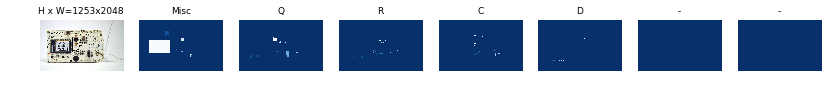

1


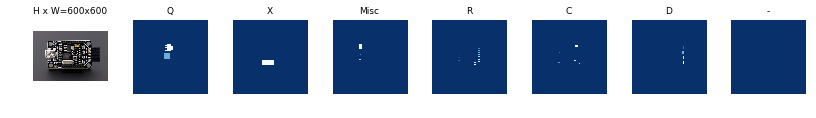

4


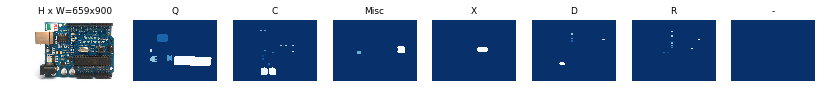

13


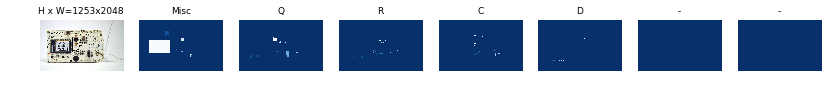

14


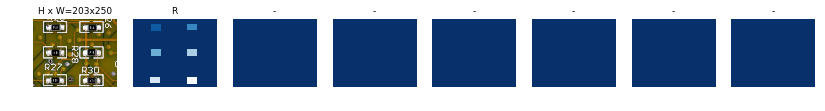

8


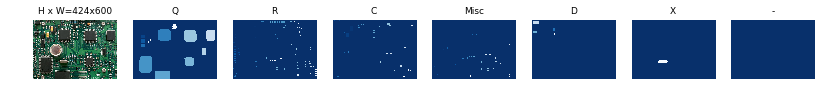

7


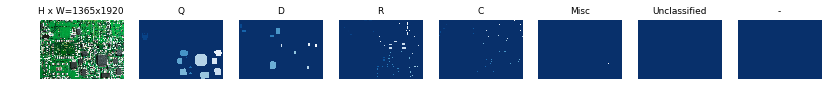

17


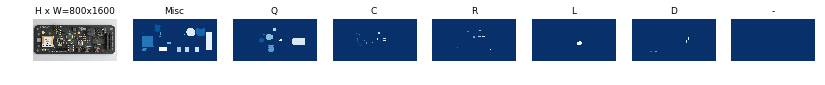

2


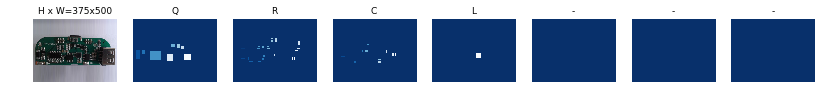

10


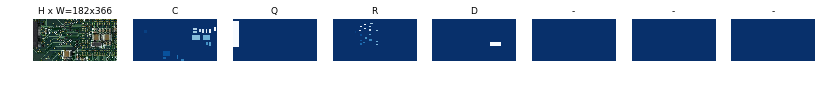

5


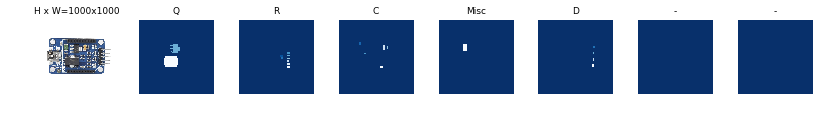

17


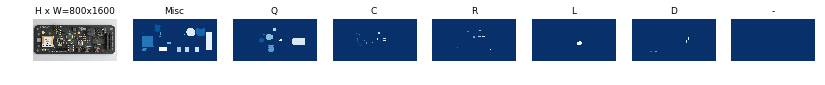

7


In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 15)
for image_id in image_ids:    
    image = dataset_train.load_image(image_id)    
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [24]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [69]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [71]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_train, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\PycharmProjects\Mask_RCNN\logs\shapes20171217T2206\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

C:\Users\Carl\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Carl\Anaconda3\lib\site-packages\keras\engine\training.py:2057: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


AttributeError: Can't pickle local object 'GeneratorEnqueuer.start.<locals>.data_generator_task'

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))